In [1]:
import os
import sys
import tifffile as tiff
import numpy as np
import dask.array as da
import matplotlib.pyplot as plt

sys.path.append("/home/phillip/documents/lysozyme")
import src
from src.lysozyme_stain_quantification.crypts.identify_potential_crypts_ import identify_potential_crypts

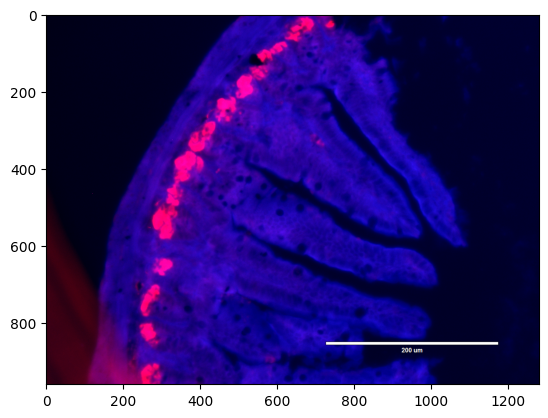

In [2]:

from src.lysozyme_stain_quantification.crypts.remove_edge_touching_regions_mod import remove_edge_touching_regions_sk
from src.lysozyme_stain_quantification.crypts.scoring_selector_mod import scoring_selector

max_regions = 10
image = tiff.imread("/home/phillip/documents/lysozyme/lysozyme images/Jej LYZ/G2/G2FL - 3.tif")
plt.imshow(image)

In [3]:

rfp = image[...,0]
dapi = image[...,2]


regions = remove_edge_touching_regions_sk(identify_potential_crypts(
    crypt_img=rfp,
    tissue_image=dapi,
    blob_size_px=int(50.0 * 0.4476),
))
best_crypts, crypt_scores = scoring_selector(
        label_img=regions,
        raw_img=rfp,
        max_regions=max_regions,
        return_details=True,
    )


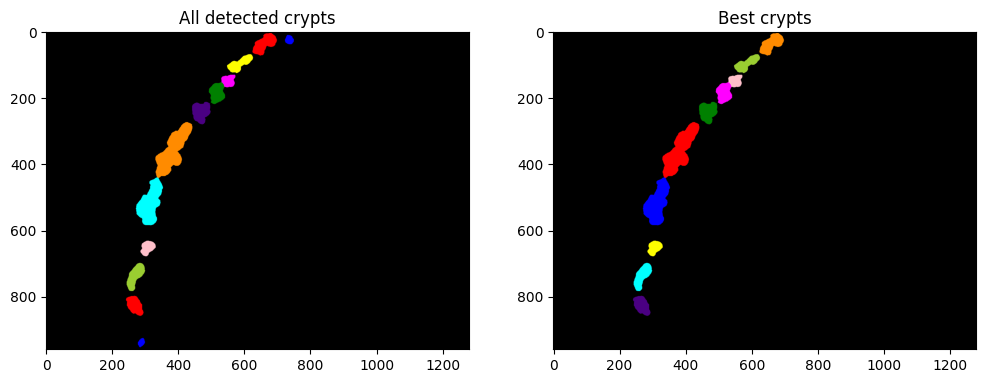

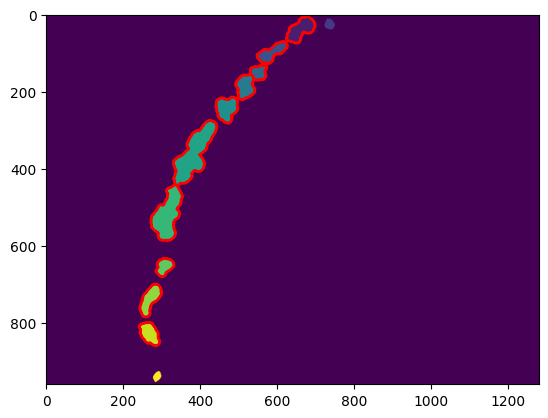

In [4]:
from skimage.color import label2rgb 
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].imshow(label2rgb(regions)); ax[0].set_title("All detected crypts")
ax[1].imshow(label2rgb(best_crypts)); ax[1].set_title("Best crypts")
plt.show()
from skimage.segmentation import find_boundaries
boundaries = find_boundaries(best_crypts)
subject = np.zeros_like(image)
subject[boundaries] = [255,0,0]
plt.imshow(regions)
plt.contour(boundaries, colors='r')

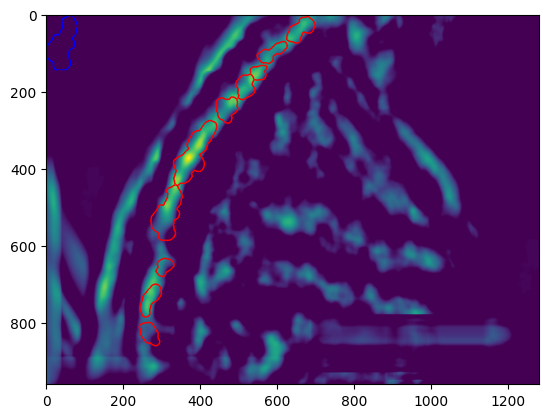

In [12]:
import scipy.ndimage as ndi
from skimage.feature import match_template
from skimage.restoration import inpaint

crypt_index = 2  # Index of the crypt to match
subject = rfp  # Image in which to search for matches


def find_matches(detections: np.ndarray, index: int, src: np.ndarray, pad_input=True):
    #template_boundaries = find_boundaries(detections == index)
    slc = ndi.find_objects(detections == index)[0]

    crypt_binary = detections == index if src.ndim == 2 else np.stack([detections == index]*src.shape[-1], axis=-1)
    template = np.where(crypt_binary, src, np.zeros_like(src))
    template = template[slc]
    result = match_template(src, template, pad_input=pad_input)
    
    result = inpaint.inpaint_biharmonic(result, detections == index, channel_axis=None)
    result = np.maximum(result, 0)  # Collapse channel axis if present
    result = (255*(result - np.min(result)) / (np.max(result) - np.min(result)) ) # Normalize to 255
    result = result.astype(np.uint8)
    return result, template, slc

result, template, slc = find_matches(best_crypts, crypt_index, subject, pad_input=True)



plt.imshow(result)
plt.contour(find_boundaries(best_crypts), colors='r', linewidths=0.5)
plt.contour(find_boundaries(best_crypts[slc]), colors='b', linewidths=0.5)
plt.show()



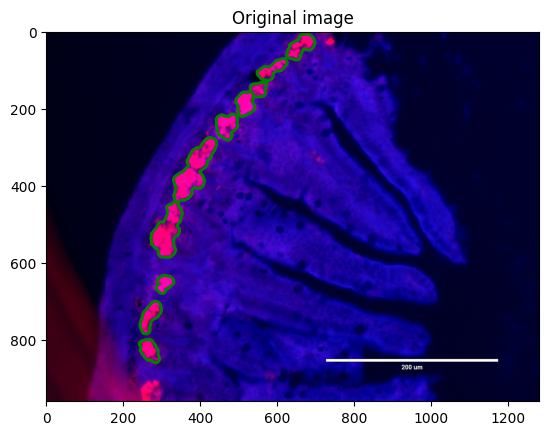

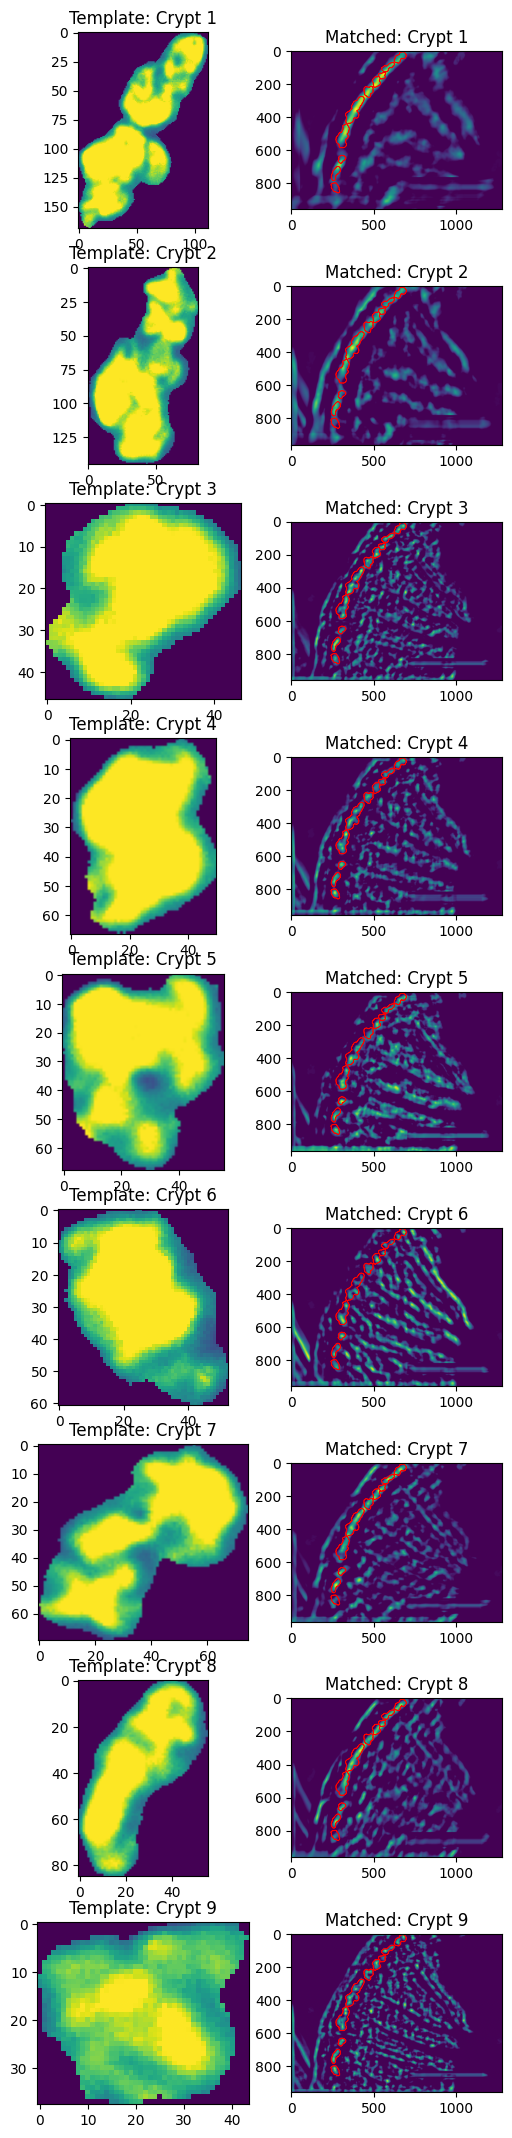

In [13]:
import scipy.ndimage as ndi
from skimage.feature import match_template


# show original image
plt.imshow(image)
plt.title("Original image")
plt.contour(find_boundaries(best_crypts), colors='g')
plt.show()
num_crypts = np.max(best_crypts)-1

fig, ax = plt.subplots(num_crypts,2, figsize=(6,3*num_crypts))
subject = rfp
boundaries = find_boundaries(best_crypts)

match_indexes = []

for crypt_index in range(0, num_crypts):

    
    subject = rfp
    result, template, slc = find_matches(best_crypts, crypt_index+1, subject, pad_input=True)
    ax[crypt_index, 0].imshow(template)
    ax[crypt_index, 0].set_title(f"Template: Crypt {crypt_index+1}")
    
    ax[crypt_index, 1].imshow(result)
    ax[crypt_index, 1].contour(boundaries, colors='r', linewidths=0.5)
    

    ax[crypt_index, 1].set_title(f"Matched: Crypt {crypt_index+1}")
    #ax[crypt_index, 2].imshow(match_template(slc, best_crypts, pad_input=True))

    match_indexes.append(result)

plt.show()





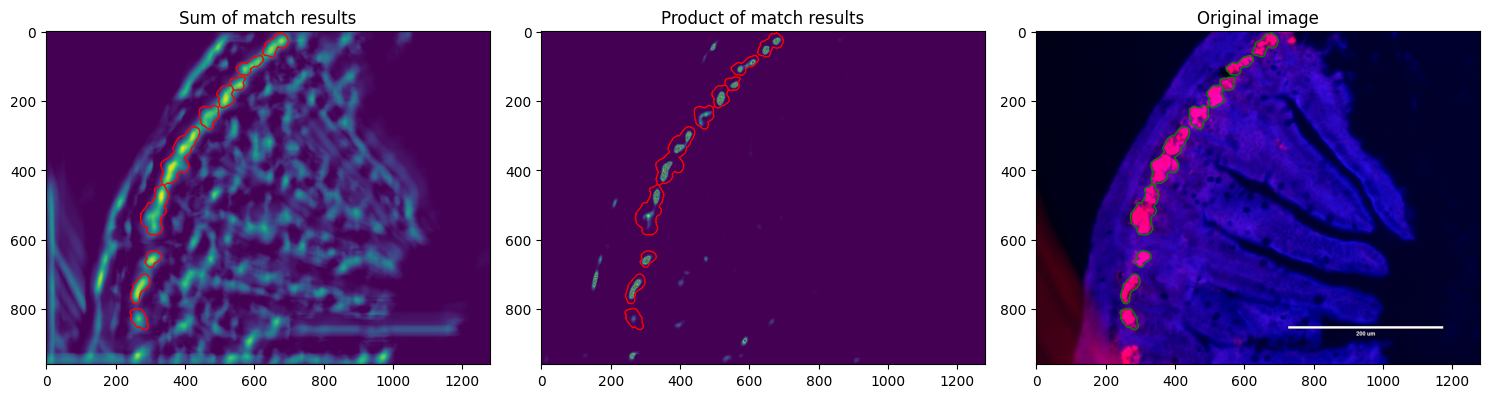

In [14]:
from scipy.stats import gmean
result_stack = np.stack(match_indexes)
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(np.sum(result_stack, axis=0))
ax[0].set_title("Sum of match results")
ax[0].contour(boundaries, colors='r', linewidths=0.5)   
collapsed_results =np.multiply.reduce(result_stack)

ax[1].imshow(collapsed_results)
ax[1].set_title("Product of match results")
ax[1].contour(boundaries, colors='r', linewidths=0.5)
ax[2].imshow(image)
ax[2].set_title("Original image")
ax[2].contour(boundaries, colors='g', linewidths=0.5)
fig.tight_layout()
fig.show()

# plt.imshow(np.multiply.reduce(result_stack))
# plt.contour(boundaries, colors='r', linewidths=0.5)

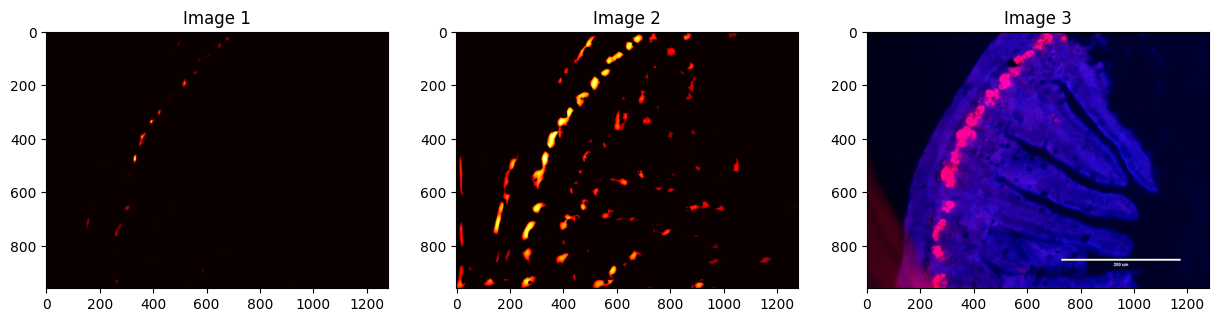

In [9]:
from skimage.morphology import dilation, erosion, disk
from skimage.util import img_as_int

def dynamic_show(images: list[np.ndarray]):
    fig, ax = plt.subplots(1, len(images), figsize=(15, 5))
    for i, img in enumerate(images):
        ax[i].imshow(img, cmap='hot')
        ax[i].set_title(f"Image {i+1}")
    plt.show()

results_geometric = gmean(
    img_as_int(np.maximum(result_stack, 0))
    , axis=0)

dynamic_show([img_as_int(collapsed_results), results_geometric, image])

In [9]:
from skimage.morphology import  local_maxima
plt.hist(collapsed_results.ravel(), bins=50)
plt.show()
plt.imshow(, cmap='hot')

SyntaxError: invalid syntax (1951340483.py, line 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


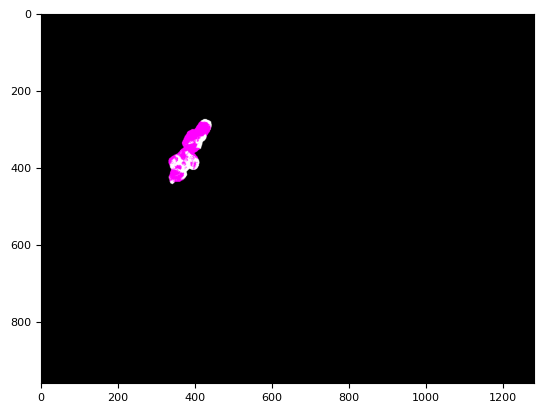

In [ ]:
def autocrop_whitespace(img, template):
    # mask of *content* pixels (not near-white)
    
    # if img.ndim == 3:
    #     content = ~(img >= 255 - tol).all(axis=-1)
    # else:
    #     content = img < 255 - tol
    # slc = ndi.find_objects(content.astype(np.uint8))[0]
    # return np.nan_to_num(img[slc], nan=0)
    slc = ndi.find_objects(template)



# maps:
template_index = 1
template = np.where(best_crypts==1, 1, np.nan)

binary_template = autocrop_whitespace(template)
rfp_template = autocrop_whitespace(rfp * template)
rgb_template = autocrop_whitespace(image * np.dstack([template]*3))


plt.imshow(rgb_template)

In [ ]:
import numpy as np
from scipy import ndimage as ndi

def autocrop_whitespace(img, tol=10):
    # mask of *content* pixels (not near-white)
    if img.ndim == 3:
        content = ~(img >= 255 - tol).all(axis=-1)
    else:
        content = img < 255 - tol
    slc = ndi.find_objects(content.astype(np.uint8))[0]
    return img[slc]

template = np.where((best_crypts==4)[...,None], image,[[[0,0,0]]])
template = autocrop_whitespace(template, tol=10)
template = np.nan_to_num(template, nan=0)
from skimage.feature import match_template
result = match_template(image, template, pad_input=False)
fig, ax = plt.subplots(1,2, figsize=(6,12))
ax[0].imshow(template); ax[0].set_title("template Image")
ax[1].imshow(rfp, cmap="viridis"); ax[1].set_title("Template Matching Result")
plt.show()
plt.imshow(result, cmap="viridis"); plt.title("Template Matching Result"); plt.show()
plt.show()

print("Max match value:", np.max(result))

KeyboardInterrupt: 

In [ ]:
import numpy as np
from scipy import ndimage as ndi

def autocrop_whitespace(img, tol=10):
    # mask of *content* pixels (not near-white)
    if img.ndim == 3:
        content = ~(img >= 255 - tol).all(axis=-1)
    else:
        content = img < 255 - tol
    slc = ndi.find_objects(content.astype(np.uint8))[0]
    return np.nan_to_num(img[slc], nan=0)

template = np.where((best_crypts==4)[...,None], 1, np.nan)
template = autocrop_whitespace(template, tol=10)
template = np.nan_to_num(template, nan=0)
from skimage.feature import match_template
result = match_template(regions, template, pad_input=False)
fig, ax = plt.subplots(1,2, figsize=(6,12))
ax[0].imshow(template); ax[0].set_title("template Image")
ax[1].imshow(rfp, cmap="viridis"); ax[1].set_title("Template Matching Result")
plt.show()
plt.imshow(result, cmap="viridis"); plt.title("Template Matching Result"); plt.show()
plt.show()

print("Max match value:", np.max(result))

ValueError: Dimensionality of template must be less than or equal to the dimensionality of image.